# Bitcoin Marketplace Rating Predictions
Features:
- Normalized target graph features
- Difference between nomalized graph target and source
- Aggregate rating metrics target
- Aggregate rating metrics source 

In [111]:
import pandas as pd
import numpy as np
from functools import reduce
import itertools

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve


import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import features as f
import time

#### Import Model Features

In [112]:
# Load Data
df_historical_target = pd.read_csv('../data/historical_target_features.csv')
df_historical_source = pd.read_csv('../data/historical_source_features.csv')
df_graph_target = pd.read_csv('../data/graph_target_features.csv')    
df_graph_source = pd.read_csv('../data/graph_source_features.csv')        

In [113]:
def subset_mask(df_historical, type):
    if type == 'fraud':
        return df_historical[(df_historical['num_neg_received']==0) & 
                             (df_historical['num_pos_received']>=3) & 
                             ((df_historical['rating']>0) | (df_historical['rating']==-10))]    
    elif type == 'suspicious':
        return df_historical[(df_historical_target['num_neg_received']==0) & 
                             (df_historical_target['num_pos_received']>=3) &
                             (df_historical['rating']>-10)]    
    elif type == 'all':
        return df_historical[(df_historical_target['num_neg_received']==0) & 
                             (df_historical_target['num_pos_received']>=3)]
    else:
        return df_historical

In [114]:
mask = subset_mask(df_historical_target, "fraud")
merge_cols = ['ratee','rater','date','rating']

df_gs = f.normalize_source_graph_metrics(df_graph_source)
df_gt = f.normalize_target_graph_metrics(df_graph_target)

df_gt.drop(['color', 'penwidth'], inplace=True, axis=1)
df_gs.drop(['color', 'penwidth'], inplace=True, axis=1)
df_historical_target.drop(['color', 'penwidth'], inplace=True, axis=1)
df_historical_source.drop(['color', 'penwidth'], inplace=True, axis=1)

df_lst = [df_historical_target, df_historical_source]
df_hh = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), df_lst)
df_hh = df_hh[df_hh.index.isin(mask.index)]

df_lst = [df_gt, df_gs]
df_g = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), df_lst)
df_gg = f.graph_metrics_source_target_difference(df_g)
df_gg = df_gg[df_gg.index.isin(mask.index)]

df_lst= [df_hh, df_gg]
df_all = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), df_lst)  

### Fit and Predict Feature Categories

In [116]:
model = RandomForestClassifier(bootstrap = True,
                                     max_depth = 35,
                                     max_features = 5,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     n_estimators = 1800,
                                     n_jobs=-1,
                                     random_state=123)

In [117]:
def predict_on_features(df):
    X = df.copy()
    y = np.where(X['rating']<0, 1, 0)
    X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    random_state=123)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba)
    fpr, tpr, threshold = roc_curve(y_test, proba)
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    thresh = 0.1
    cnf_matrix = confusion_matrix(y_test, proba>=thresh)
    return pred, proba, precision, recall, thresholds, f1, cnf_matrix, fpr, tpr, threshold, accuracy, model 

In [118]:
hh_pred, hh_proba, hh_precision, hh_recall, hh_thresholds, hh_f1, hh_cm, hh_fpr, hh_tpr, hh_threshold, hh_accuracy, hh_model = predict_on_features(df_hh)
gg_pred, gg_proba, gg_precision, gg_recall, gg_thresholds, gg_f1, gg_cm, gg_fpr, gg_tpr, gg_threshold, gg_accuracy, gg_model = predict_on_features(df_gg)
a_pred, a_proba, a_precision, a_recall, a_thresholds, a_f1, a_cm, a_fpr, a_tpr, a_accuracy, a_threshold, a_model = predict_on_features(df_all)

#### ROC AUC Plot

In [47]:
def roc_curve(ax):
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(gg_fpr, gg_tpr, 'r', label = f"Graph Features f1: {gg_f1:.2f} AUC:{auc(gg_fpr, gg_tpr):.2f}")
    ax.plot(hh_fpr, hh_tpr, 'g', label = f"Ratings Features f1: {hh_f1:.2f} AUC: {auc(hh_fpr, hh_tpr):.2f}")
    ax.plot(a_fpr, a_tpr, 'b', label = f"All Features (f1: {a_f1:.2f} AUC: {auc(a_fpr, a_tpr):.2f}")
    ax.legend(loc = 'lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

#### Precision Recall Curve

In [48]:
def pr_curve(ax):
    ax.set_title("Precision Recall Curve")
    ax.plot(gg_recall, gg_precision, alpha=0.8, c='r')
    ax.plot(hh_recall, hh_precision, alpha=0.8, c='g')
    ax.plot(a_recall, a_precision, alpha=0.8, c='b')
    
    thresh = 0.1
    threshold_idx = np.argmin(np.abs(a_thresholds-thresh))
    ax.plot(a_recall[threshold_idx], 
            a_precision[threshold_idx],  
            'o', c='b', markersize=8, fillstyle='full', 
             label=f"{thresh:.2f} threshold", mew=2)               

    threshold_idx = np.argmin(np.abs(gg_thresholds-thresh))
    ax.plot(gg_recall[threshold_idx], 
            gg_precision[threshold_idx],  
            'o', c='r', markersize=8, fillstyle='full', 
             label=f"{thresh:.2f} threshold", mew=2)               

    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left", frameon=False)

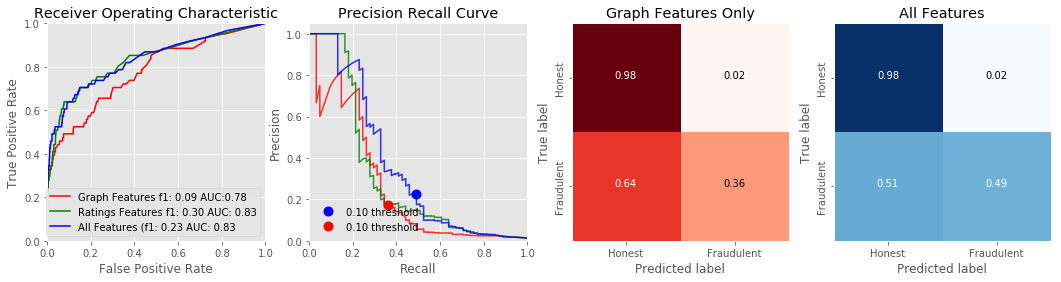

In [49]:
fig, axs = plt.subplots(1,4,figsize=(18,4))
roc_curve(axs[0])
pr_curve(axs[1])
v.plot_confusion_matrix(axs[2], gg_cm, 
                      classes=['Honest','Fraudulent'], 
                      normalize=True,
                      title='Graph Features Only',
                      cmap=plt.cm.Reds)

v.plot_confusion_matrix(axs[3], a_cm, 
                      classes=['Honest','Fraudulent'], 
                      normalize=True,
                      title='All Features')
plt.show()

### Feature Importance

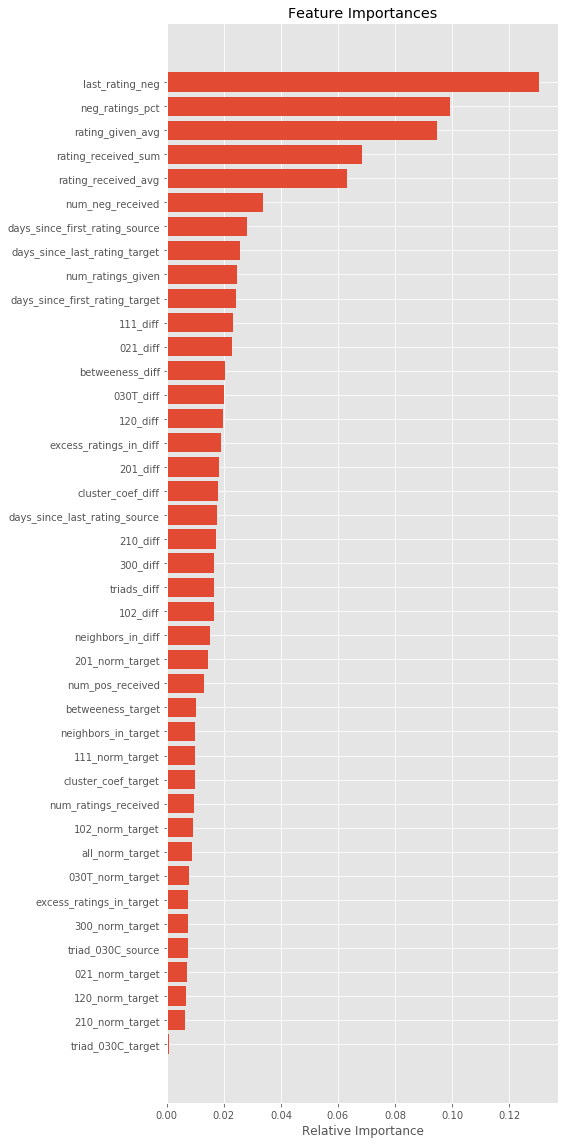

In [12]:
X = df_all.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
features=X.columns
importances = a_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8,16))
ax.set_title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

### Collusion Example

In [ ]:
X_test[y_test==1]

In [ ]:
# Predict on Example 
x_pred = features_df[(features_df['ratee']==4986)].copy()
model = RandomForestClassifier(n_jobs=-1,
                               random_state=123)
model.fit(X_train, y_train)
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features

In [ ]:
# Predict on Example (with no features)
model_ng = RandomForestClassifier(n_jobs=-1,
                                  random_state=123)
model_ng.fit(X_train, y_train)
x = features_df_ng[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

In [ ]:
x_pred = features_df_ng[(features_df_ng['ratee']==4986)].copy()

x = x_pred.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = x.pop('class')

# run model without graph features
pred_no_features = model_ng.predict_proba(x)[:,1]
x_pred = x_pred[['ratee','date','rating']]
x_pred['prediction_without_features'] = pred_no_features

In [ ]:
# rerun model with graph features
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date'], axis=1, inplace=True)
y = x.pop('class')

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features
x_pred